### **Notebook Test**

C'est un notebook à la fois pour les tests, mais aussi pour faire un suivi du projet. Il sera supprimé, soit réagencé à la fin. Mais bon à l'heure où j'écris ça, je n'ai même pas commencé le projet.


### **Prepare_data**

Le but de cette partie est de décortiquer le fichier "prepare_data.py" pour ne pas faire de la merde après.


Le script est trop long et contient plusieurs boucles.

Voilà ce qu'il est censé faire :
:
Découpe B8 (10 m) en patchs 64×64 et B8A (20 m) en patchs 32×32.

Downscale B8 → 32×32 pour créer les entrées LR pour l’entraînement.

Upscale B8A → 64×64 pour l’inférence.

Création de tensors PyTorch :

tensor_b8.pt / tensor_b8_ds.pt pour l’entraînement (LR → HR)

tensor_b8a.pt / tensor_b8a_us.pt pour l’inférence.

### LIB

In [1]:
%pip install torchmetrics
%pip install rasterio
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.4 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/25.4 MB 12.2 MB/s eta 0:00:02
   ------- -------------------------------- 5.0/25.4 MB 11.2 MB/s eta 0:00:02
   -------------- ------------------------- 8.9/25.4 MB 14.1 MB/s eta 0:00:02
   ------------------- -------------------- 12.6/25.4 MB 14.8 MB/s eta 0:00:01
   ---------------------------- ----------- 17.8/25.4 MB 16.8 MB/s eta 0:00:01
   ----------------------------------- ---- 22.5/25.4 MB 17.9 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 17.6 MB/s  0:00:01

   ---------------------------------------- 0/5 [click]
   ---------------------------------------- 0/5 [click]
   ---------------- ----------------------- 2/5 [cligj]
   -------------------------------- ------- 4/5 [rasterio]
   ----------------

In [2]:
# # lancer .py %run path/to/script.py --epochs 50 --lr 1e-3
# %run prepare_data.py 
# %run reconstruct_image.py 

### Début

X_hr shape: torch.Size([29241, 64, 64])
X_lr shape: torch.Size([29241, 32, 32])


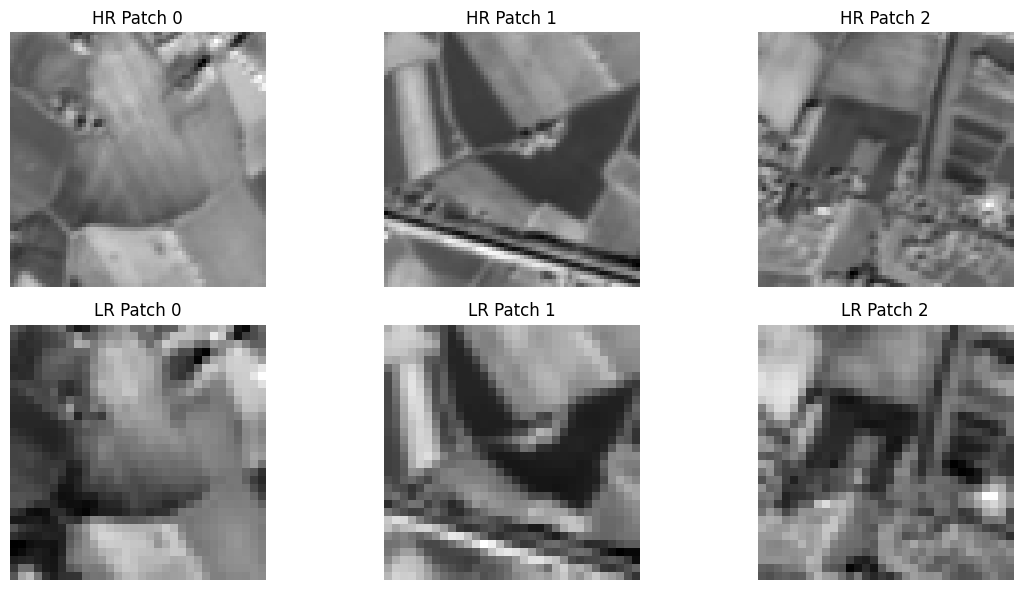

In [3]:
import torch
import matplotlib.pyplot as plt
import os

# Chemins vers les tenseurs
tensor_b8_path = "tensor_b8.pt"
tensor_b8_ds_path = "tensor_b8_ds.pt"

# Charger les tensors
X_hr = torch.load(tensor_b8_path)      # HR (High-Resolution) patches B8
X_lr = torch.load(tensor_b8_ds_path)   # LR (Low-Resolution) patches B8 downscaled

# Informations sur les tensors
print("X_hr shape:", X_hr.shape)
print("X_lr shape:", X_lr.shape)

# Visualiser les 3 premiers patchs
num_patches = 3
plt.figure(figsize=(12, 6))

for k in range(num_patches):
    img_hr = X_hr[k].numpy()
    img_lr = X_lr[k].numpy()

    # Affichage HR
    plt.subplot(2, num_patches, k+1)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # Affichage LR
    plt.subplot(2, num_patches, k+1+num_patches)
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Préparations des données d'entraînement
import random
from torch.utils.data import DataLoader

# --- Copie des données pour ne pas écraser les originaux
X = X_lr.float()
Y = X_hr.float()

# --- Normalisation entre 0 et 1
X = X / X.max()
Y = Y / Y.max()

# --- Flip et rotations aléatoires
num_patches = X.shape[0]

for i in range(num_patches):
    # Flip horizontal
    if random.random() > 0.5:
        X[i] = torch.flip(X[i], [-1])
        Y[i] = torch.flip(Y[i], [-1])

    # Flip vertical
    if random.random() > 0.5:
        X[i] = torch.flip(X[i], [-2])
        Y[i] = torch.flip(Y[i], [-2])

    # Rotation 0°, 90°, 180°, 270°
    k = random.randint(0, 3)
    X[i] = torch.rot90(X[i], k, [0,1])
    Y[i] = torch.rot90(Y[i], k, [0,1])


# Ratios
train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

# Création d'un dataset
dataset = torch.utils.data.dataset.TensorDataset(X.unsqueeze(1), Y.unsqueeze(1))

# Séparation des données
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
valid_size = int(valid_ratio * num_samples)
test_size = num_samples - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.dataset.random_split(
    dataset, [train_ratio, valid_ratio, test_ratio]
)

# Création de Data-Loaders pour entraîner le réseau
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Print pour avoir une idée des tailles des datasets
print("Nombre d’échantillons :", num_samples,'\n')
print("Taille du dataset d’entraînement :", len(train_dataset))
print("Taille du dataset de validation :", len(valid_dataset))
print("Taille du dataset de test :", len(test_dataset),'\n')
print("Exemple d'échantillon : ", dataset[0][0].shape, ",", dataset[0][1].shape)

Nombre d’échantillons : 29241 

Taille du dataset d’entraînement : 20469
Taille du dataset de validation : 2924
Taille du dataset de test : 5848 

Exemple d'échantillon :  torch.Size([1, 32, 32]) , torch.Size([1, 64, 64])


## SSIM, PSNR, (LPIPS?) pour interpolation Bicubic et visualisation

In [6]:
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

X_up = F.interpolate(X.unsqueeze(1), scale_factor=2, mode="bicubic", align_corners=False)

X_up = X_up.clamp(0.0, 1.0)

psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

print("Bicubic PSNR:", psnr(X_up, Y.unsqueeze(1)).item())
#print("Bicubic SSIM:", ssim(X_up, Y.unsqueeze(1)).item()) # sur gpu uniquement

cpu
Bicubic PSNR: 26.60638999938965


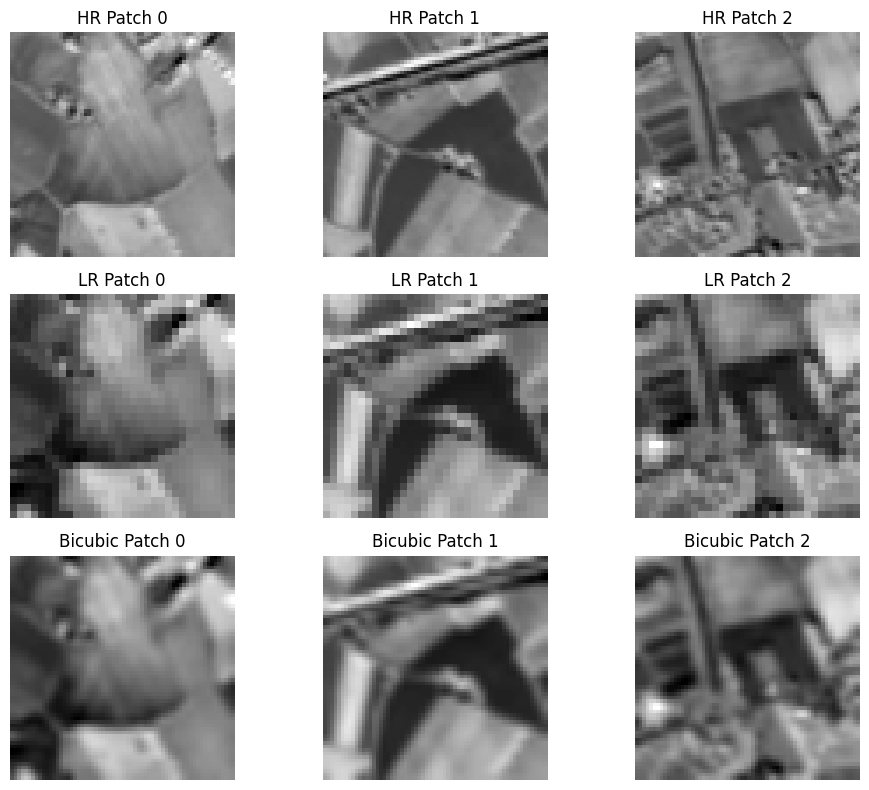

In [7]:
# Visualiser les 3 premiers patchs: HR, LR, UP
num_patches = 3
rows = 3
cols = num_patches

plt.figure(figsize=(10, 8))
for k in range(num_patches):
    img_hr = Y[k].numpy()                       # (64, 64)
    img_lr = X[k].numpy()                       # (32, 32)
    img_up = X_up[k].squeeze().numpy()          # (64, 64)

    # ----- HR (ligne 1) -----
    plt.subplot(rows, cols, 1 + k)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # ----- LR (ligne 2) -----
    plt.subplot(rows, cols, cols + 1 + k)       
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

    # ----- UP (ligne 3) -----
    plt.subplot(rows, cols, 2*cols + 1 + k)    
    plt.imshow(img_up, cmap='gray')
    plt.title(f"Bicubic Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# test: conv relu conv relu upsample
class Premier_modele(nn.Module):
    def __init__(self):
        super().__init__()
        # Extraction de features de taille 32x32
        self.feat = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        # Upsampling x2 : 32x32 -> 64x64
        self.up = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        x = self.feat(x)         
        x = self.up(x)           
        x = torch.sigmoid(x)     # on force dans [0,1]
        return x


## Training

In [ ]:
# Configuration de base
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Modèle à définir
model = Premier_modele().to(device)

# --- Fonction de perte
criterion = nn.MSELoss() # nn.L1Loss()

# --- Learning rate
learning_rate = 1e-3

# --- Optimiseur (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Nombre d'époques
num_epochs = 10

# --- Variables pour suivi
train_losses = []
valid_losses = []
best_valid_loss = float('inf')

# Boucle d'entraînement
for epoch in range(num_epochs):
    # --- Entraînement ---
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_val, Y_val in valid_loader:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, Y_val)
            valid_loss += loss.item() * X_val.size(0)

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f} - Valid Loss: {valid_loss:.6f}")
    
    # --- Sauvegarde si meilleur modèle ---
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best model saved with Valid Loss = {valid_loss}")

    




Using device: cpu
Best model saved with Valid Loss = 0.0001413561698372913
Epoch [1/10] - Train Loss: 0.001458 - Valid Loss: 0.000141
Best model saved with Valid Loss = 0.00012442201993910075
Epoch [2/10] - Train Loss: 0.000131 - Valid Loss: 0.000124
Best model saved with Valid Loss = 0.00011914732474859207
Epoch [3/10] - Train Loss: 0.000122 - Valid Loss: 0.000119
Best model saved with Valid Loss = 0.00011614510868663266
Epoch [4/10] - Train Loss: 0.000118 - Valid Loss: 0.000116
Best model saved with Valid Loss = 0.00011387282810911279
Epoch [5/10] - Train Loss: 0.000116 - Valid Loss: 0.000114
Best model saved with Valid Loss = 0.00011228045313334011
Epoch [6/10] - Train Loss: 0.000114 - Valid Loss: 0.000112
Epoch [7/10] - Train Loss: 0.000113 - Valid Loss: 0.000113
Best model saved with Valid Loss = 0.00011210027628574423
Epoch [8/10] - Train Loss: 0.000112 - Valid Loss: 0.000112
Best model saved with Valid Loss = 0.00010897474555228933
Epoch [9/10] - Train Loss: 0.000111 - Valid Los

## Prediction + Eval + visu

In [ ]:
model = model.to(device)
model.eval()

psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# listes pour stocker les prédictions et ground truths
all_pred = []
all_gt   = [] 

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        
        X_batch = X_batch.float()
        Y_batch = Y_batch.float()

        # sécurité mais pas sur d'en avoir besoin
        X_batch = X_batch.clamp(0.0, 1.0).to(device)
        Y_batch = Y_batch.clamp(0.0, 1.0).to(device)

        # Prédiction modèle (32→64)
        Y_pred = model(X_batch).clamp(0.0, 1.0)

        all_pred.append(Y_pred.cpu())
        all_gt.append(Y_batch.cpu())

# Concaténer toutes les prédictions / ground truths
Y_sr = torch.cat(all_pred, dim=0)   # (N_test,1,64,64)
Y_hr = torch.cat(all_gt, dim=0)     # (N_test,1,64,64)

# Calcul PSNR / SSIM sur le test set
model_psnr = psnr_metric(Y_sr.to(device), Y_hr.to(device)).item()
#model_ssim = ssim_metric(Y_sr.to(device), Y_hr.to(device)).item() #gpu uniquement

print(f"Model TEST PSNR: {model_psnr:.2f} dB")
#print(f"Model TEST SSIM: {model_ssim:.4f}") 

Model TEST PSNR: 39.65 dB


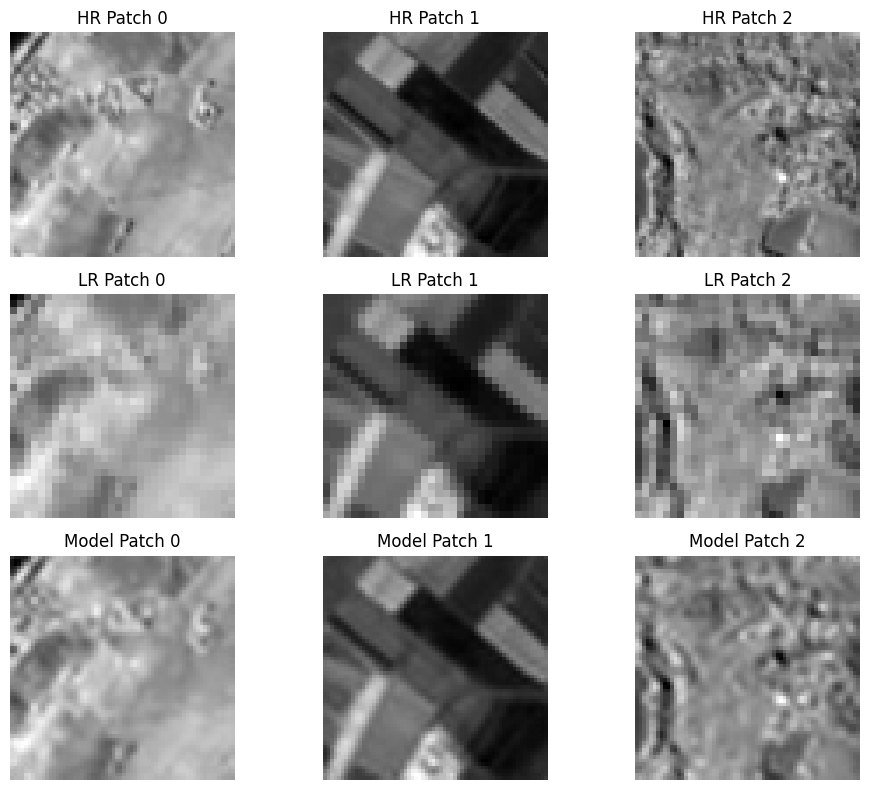

In [ ]:
# Récupérer un batch pour la visualisation
X_vis, Y_vis = next(iter(test_loader))

X_vis = X_vis.float()
Y_vis = Y_vis.float()

# sécurité mais pas sur d'en avoir besoin
X_vis = X_vis.clamp(0.0, 1.0).to(device)
Y_vis = Y_vis.clamp(0.0, 1.0).to(device)

with torch.no_grad():
    Y_sr_vis = model(X_vis).clamp(0.0, 1.0)

# Revenir sur CPU pour matplotlib
X_vis_cpu   = X_vis.cpu()
Y_vis_cpu   = Y_vis.cpu()
Y_sr_vis_cpu = Y_sr_vis.cpu()

num_patches = 3
rows = 3
cols = num_patches

plt.figure(figsize=(10, 8))

for k in range(num_patches):
    img_hr = Y_vis_cpu[k].squeeze().numpy()      # (64,64)
    img_lr = X_vis_cpu[k].squeeze().numpy()      # (32,32)
    img_sr = Y_sr_vis_cpu[k].squeeze().numpy()   # (64,64)

    # ----- HR (ligne 1) -----
    plt.subplot(rows, cols, 1 + k)
    plt.imshow(img_hr, cmap='gray')
    plt.title(f"HR Patch {k}")
    plt.axis('off')

    # ----- LR (ligne 2) -----
    plt.subplot(rows, cols, cols + 1 + k)
    plt.imshow(img_lr, cmap='gray')
    plt.title(f"LR Patch {k}")
    plt.axis('off')

    # ----- SR modèle (ligne 3) -----
    plt.subplot(rows, cols, 2*cols + 1 + k)
    plt.imshow(img_sr, cmap='gray')
    plt.title(f"Model Patch {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()
